In [89]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [90]:
df = data.load_asset('DOGEUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,0.17030,0.17370,0.16970,0.17320,2.975041e+08,5.111861e+07,78125,158466283.0,2.723658e+07,21.0,Extreme Fear
2022-01-02,0.17310,0.17630,0.17050,0.17450,3.129559e+08,5.423202e+07,103674,163325748.0,2.830660e+07,29.0,Fear
2022-01-03,0.17450,0.17450,0.16740,0.17030,4.609854e+08,7.876928e+07,139249,236643465.0,4.045470e+07,29.0,Fear
2022-01-04,0.17030,0.17260,0.16650,0.16840,4.964392e+08,8.444579e+07,127545,258358537.0,4.396345e+07,23.0,Extreme Fear
2022-01-05,0.16850,0.17100,0.14720,0.15900,1.084632e+09,1.755868e+08,307998,519468771.0,8.434797e+07,24.0,Extreme Fear
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,0.19490,0.20060,0.18771,0.19046,9.035428e+08,1.752849e+08,811855,441923704.0,8.576521e+07,40.0,Fear
2025-03-28,0.19047,0.19290,0.17721,0.18024,9.752762e+08,1.779935e+08,762040,442996940.0,8.079241e+07,44.0,Fear
2025-03-29,0.18024,0.18273,0.16584,0.16957,8.571812e+08,1.477116e+08,639587,402585989.0,6.939481e+07,26.0,Fear


In [91]:
import ta  # technical analysis library

look_back = 14

# RSI: Relative Strength Index
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

<Figure size 1200x600 with 0 Axes>

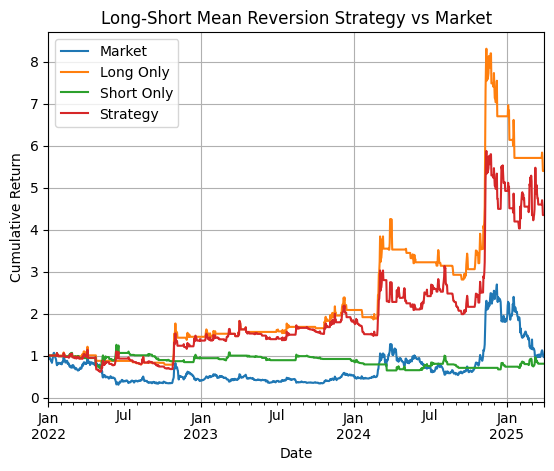

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load df
price = df['Close']

# Calculate Moving Average and Standard Deviation
window = 20
moving_avg = price.rolling(window=window).mean()
moving_std = price.rolling(window=window).std()

# Calculate Z-score
z_score = (price - moving_avg) / moving_std

df['Position'] = 0
df.loc[z_score < -1, 'Position'] = -1    # Long
df.loc[z_score > 1, 'Position'] = 1     # Short

# Shift position for realistic execution
df['Position'] = df['Position'].shift(1)

# Calculate returns
df['Market Return'] = price.pct_change()
df['Long Return'] = (df['Position'] == 1).astype(int) * df['Market Return']
df['Short Return'] = (df['Position'] == -1).astype(int) * (-df['Market Return'])
df['Strategy Return'] = df['Position'] * df['Market Return']

# Cumulative returns
cumulative_returns = (1 + df[['Market Return', 'Long Return', 'Short Return', 'Strategy Return']]).cumprod()

# Plot
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Long-Short Mean Reversion Strategy vs Market')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend(['Market', 'Long Only', 'Short Only', 'Strategy'])
plt.grid(True)
plt.show()

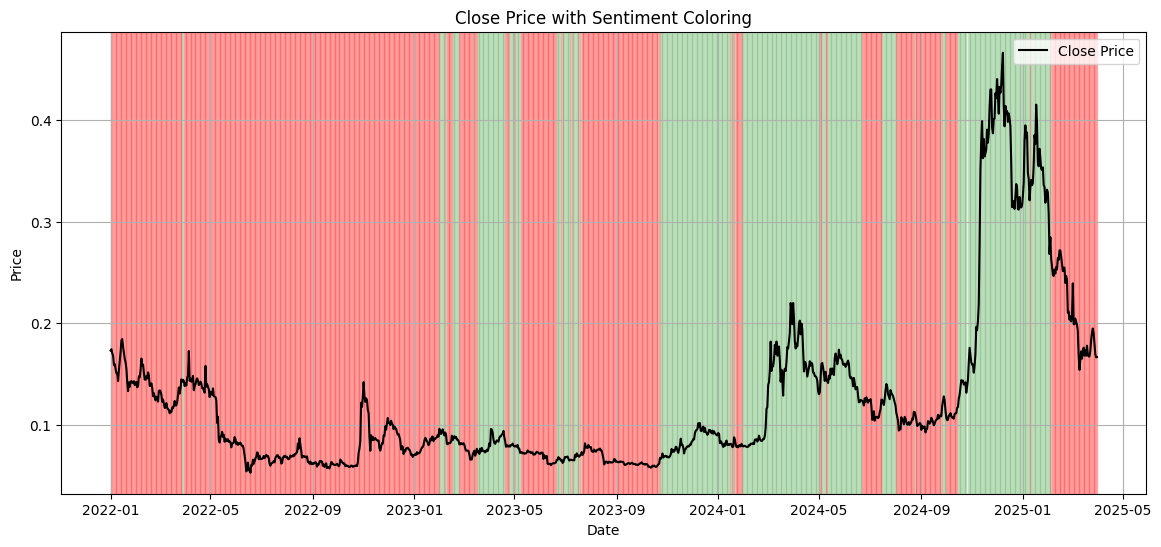

In [93]:
fear_threshold = 55
greed_threshold = 45

fig, ax = plt.subplots(figsize=(14,6))

# Plot Close price
ax.plot(df.index, df['Close'], label='Close Price', color='black')

# Color background by sentiment
for idx in range(len(df)):
    if df['F&G'].iloc[idx] <= fear_threshold:
        ax.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.3)
    elif df['F&G'].iloc[idx] >= greed_threshold:
        ax.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    else:
        ax.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

# Decorations
plt.title('Close Price with Sentiment Coloring')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

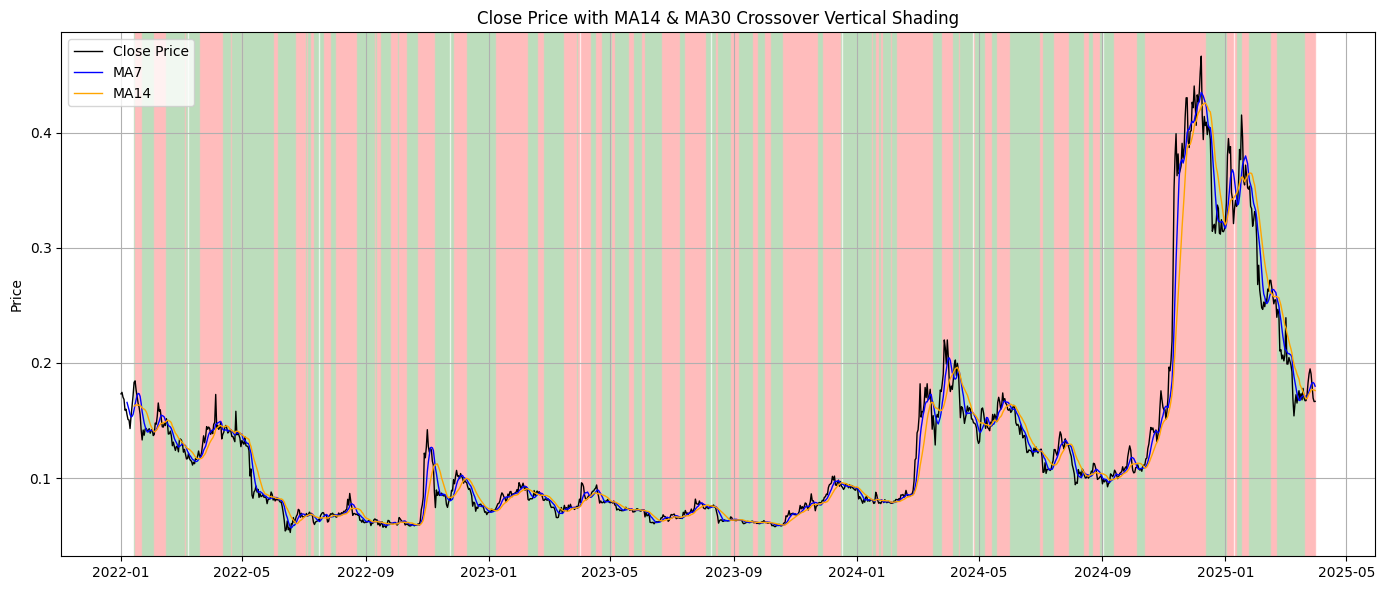

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot price and moving averages
ax.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
ax.plot(df.index, df['MA7'], label='MA7', color='blue', linewidth=1)
ax.plot(df.index, df['MA14'], label='MA14', color='orange', linewidth=1)

# Shade vertical bars based on crossover
for idx in range(len(df)):
    if np.isnan(df['MA7'].iloc[idx]) or np.isnan(df['MA14'].iloc[idx]):
        continue  # Skip NaN entries
    if df['MA7'].iloc[idx] > df['MA14'].iloc[idx]:
        ax.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.2)
    elif df['MA7'].iloc[idx] < df['MA14'].iloc[idx]:
        ax.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)

# Final decorations
ax.set_title('Close Price with MA14 & MA30 Crossover Vertical Shading')
ax.set_ylabel('Price')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()



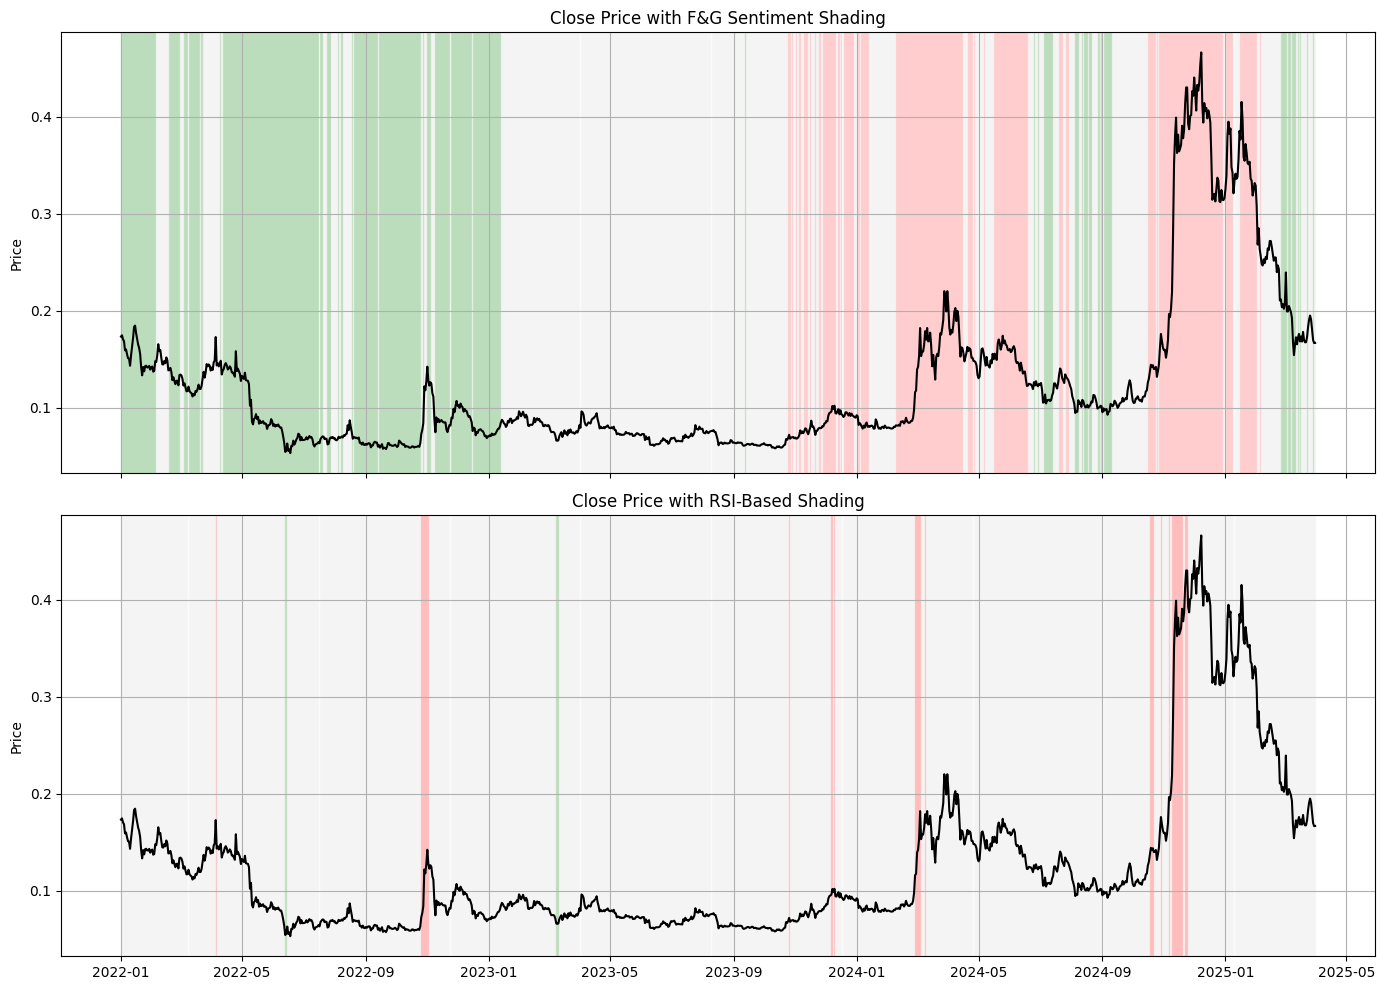

In [95]:
import matplotlib.pyplot as plt

fear_threshold = 30
greed_threshold = 70

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ======== PLOT 1: Close Price + F&G Sentiment Color ========
ax1.plot(df.index, df['Close'], label='Close Price', color='black')

for idx in range(len(df)):
    if df['F&G'].iloc[idx] <= fear_threshold:
        ax1.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    elif df['F&G'].iloc[idx] >= greed_threshold:
        ax1.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.15)
    else:
        ax1.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

ax1.set_title('Close Price with F&G Sentiment Shading')
ax1.set_ylabel('Price')
ax1.grid(True)

# ======== PLOT 2: Close Price + RSI Color ========
ax2.plot(df.index, df['Close'], label='Close Price', color='black')

for idx in range(len(df)):
    if df['RSI'].iloc[idx] > 75:
        ax2.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.2)
    elif df['RSI'].iloc[idx] < 25:
        ax2.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    else:
        ax2.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

ax2.set_title('Close Price with RSI-Based Shading')
ax2.set_ylabel('Price')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [96]:
# Conditions for Buy Signal (entry)
buy_condition = (
    (df['RSI'] < 35) &
    (df['F&G'] < 30) &
    (df['MA7'] > df['MA14'])
)

# Conditions for Exit (exit)
exit_condition = (
    (df['RSI'] > 75) |
    (df['MA7'] < df['MA14']) |
    (df['F&G'] > 70)
)

# Step 1: Only mark entries as signal = 1
df['Signal'] = 0
df.loc[buy_condition, 'Signal'] = 1

# Step 2: Create Position column
df['Position'] = np.nan

# Step 3: Apply entry signals
df.loc[df['Signal'] == 1, 'Position'] = 1

# Step 4: Exit on exit condition (set position to 0)
df.loc[exit_condition, 'Position'] = 0

# Step 5: Forward fill between entries and exits
df['Position'] = df['Position'].ffill().fillna(0)

# Step 6: Shift for next-day execution
df['Position'] = df['Position'].shift(1).fillna(0)


In [100]:
print("Buy signals triggered:", buy_condition.sum())
print("Exit signals triggered:", exit_condition.sum())


Buy signals triggered: 1
Exit signals triggered: 776


In [97]:
# Daily market return
df['Market Return'] = df['Close'].pct_change()

# Strategy return = market return only when in position
df['Strategy Return'] = df['Position'] * df['Market Return']

# Cumulative returns
df['Cumulative Market Return'] = (1 + df['Market Return']).cumprod()
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()


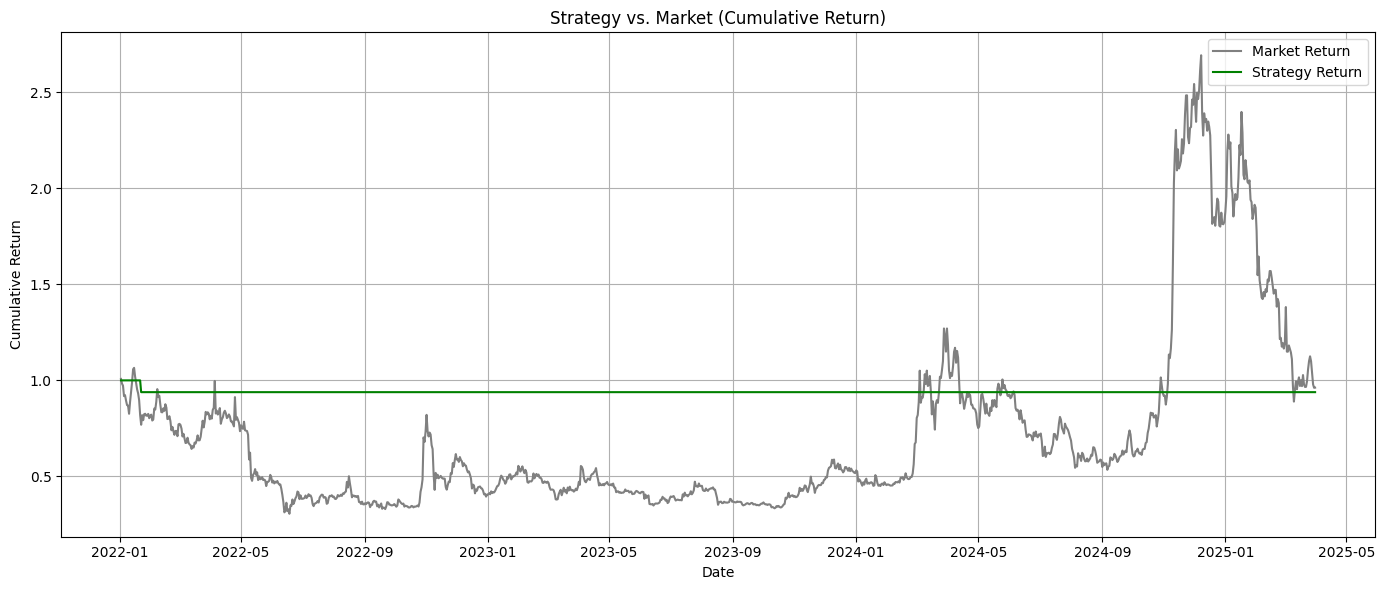

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Cumulative Market Return'], label='Market Return', color='grey')
plt.plot(df.index, df['Cumulative Strategy Return'], label='Strategy Return', color='green')
plt.title('Strategy vs. Market (Cumulative Return)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [99]:
# Step 1: Identify entry and exit signal dates
entry_dates = df[df['Entry']].index
exit_dates = df[df['Exit']].index

# Step 2: Match entries to the nearest following exits
entries = []
exits = []

exit_idx = 0
for entry_date in entry_dates:
    # Find the next exit after the current entry
    while exit_idx < len(exit_dates) and exit_dates[exit_idx] <= entry_date:
        exit_idx += 1
    if exit_idx < len(exit_dates):
        exit_date = exit_dates[exit_idx]
        entries.append(entry_date)
        exits.append(exit_date)
        exit_idx += 1

# Step 3: Build a DataFrame of trades
trade_data = {
    'Entry Date': entries,
    'Entry Price': df.loc[entries, 'Close'].values,
    'Exit Date': exits,
    'Exit Price': df.loc[exits, 'Close'].values,
}
trade_df = pd.DataFrame(trade_data)
trade_df['Return'] = (trade_df['Exit Price'] - trade_df['Entry Price']) / trade_df['Entry Price']

# Step 4: Display result
print(trade_df)




KeyError: 'Entry'